## Import Libraries

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import loads
from sklearn.cluster import KMeans
import numpy as np

## Read In and Format Data

In [5]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")
gdf = gdf.to_crs(crs='EPSG:4326')
gdf = gdf[gdf['POINT_X']!=0]
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y
tracts = gpd.read_file('../data/tracts.csv').drop(columns=['geometry'])
tracts['the_geom'] = tracts['the_geom'].apply(loads)
tracts = tracts.set_geometry('the_geom')

## Bin Data into ~1/4 Hexbins


(note - gridsize was manually calculated based on width of SD County to generate roughly 1/4 mile radius hexbins:
SD County is roughly 86 miles east to west, and the grid size takes the quantity of hexbins by width
)

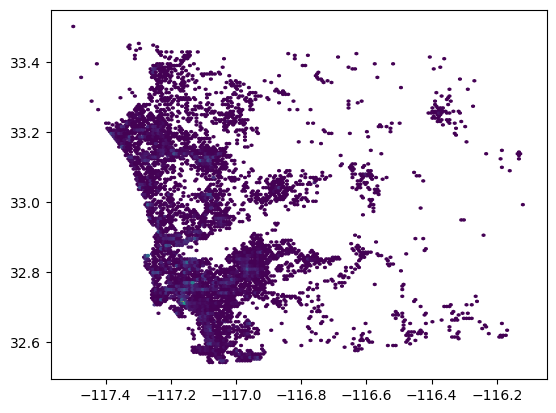

In [9]:
hexes = matplotlib.pyplot.hexbin( x= gdf['x'], y=gdf['y'],mincnt=1,gridsize=86*2)
hexbins = gpd.points_from_xy(x=[i[0] for i in hexes.get_offsets()],y=[i[1] for i in hexes.get_offsets()])[1:]

Merge the data with the newly generated hexbins

In [10]:
left_merge = gpd.GeoDataFrame(hexbins, geometry=0)

In [11]:
full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')

/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_2839/318931066.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  full_merge = gpd.sjoin_nearest(left_merge,gdf,how='right')
/Users/michaelsmith/opt/anaconda3/envs/dt_employment_center/lib/python3.12/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## Apply Manually Created Categories to Businesses

In [12]:
labels = pd.read_csv('../generate_labels.csv')
final_merge = full_merge.merge(labels, how='left', left_on='BUSTYPE',right_on='Items')
final_merge = final_merge[~final_merge['Categories'].isna()]

## Groupby Each Hexbin and Count the # of Businesses in Each Bin

In [15]:
def generate_counts(df):
    return df\
        .groupby('index_left').count()\
        .sort_values(by='x').reset_index()[['index_left','APN',]]\
        .rename(columns={'APN':'Count'})
index_and_counts = generate_counts(final_merge)

## Generate Center Points of Each Hexbin

In [20]:
def process_centers(df):
    def get_x(index):
        return hexbins[index].x
    def get_y(index):
        return hexbins[index].y
    index_and_counts['x'] = index_and_counts['index_left'].apply(get_x)
    index_and_counts['y'] = index_and_counts['index_left'].apply(get_y)
    index_and_counts['geometry'] = gpd.points_from_xy(index_and_counts['x'], index_and_counts['y'])
    return gpd.GeoDataFrame(index_and_counts)
    
_df = process_centers(index_and_counts)

## Use the 70 Largest Hexbins as 'Centers' For Clustering

In [22]:
def generate_clusters(df):
    df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
    cluster_centers = df[df['is_center']==True][['x', 'y']].values
    other_points = df[['x', 'y']].values
    k = len(cluster_centers)
    kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
    kmeans.fit(other_points)
    df['cluster'] = kmeans.labels_
    return df
_df = generate_clusters(_df)

Text(0.5, 1.0, 'Overall Clusters')

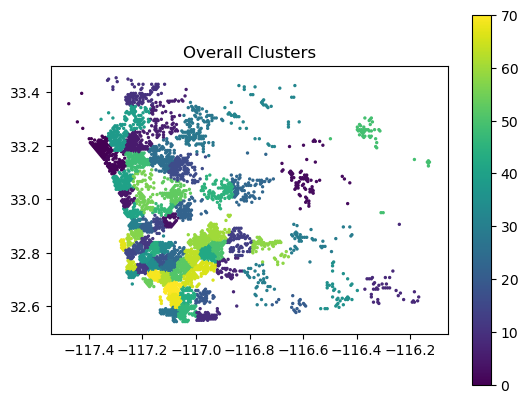

In [23]:
_df.plot(column='cluster', legend=True, markersize=2).set_title('Overall Clusters')

## Import Tracts Data

In [73]:
def merge_tracts(full,df,tracts):
    poly_df = full_merge.merge(df[['index_left','cluster']],how='left')
    geometry = poly_df['geometry'].apply(Point)
    gpdf = gpd.GeoDataFrame(poly_df, geometry=geometry)
    pre_groupby = tracts.sjoin(gpdf.drop(columns=['index_left']), how='left', predicate='contains')
    return pre_groupby.groupby('the_geom')['cluster']
groupby_tracts = merge_tracts(full_merge,_df,tracts)

## Create Final Clusters by merging Hexbins onto Nearest Tracts

<Axes: >

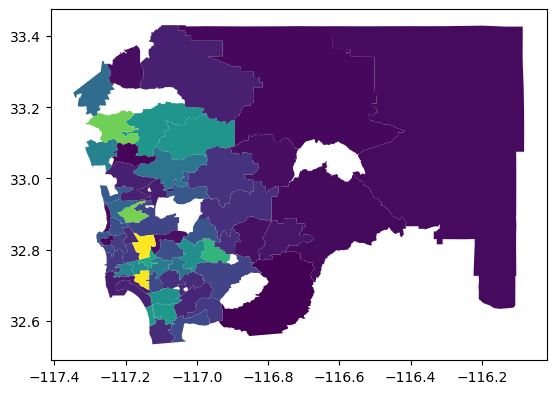

In [87]:
def geometries_to_tracts(groupby_tracts, min_per_tract=10):
    min_per_tract = 10
    clusters_tracts = groupby_tracts.agg(lambda x:x.value_counts().index[0] if x.any() and x.value_counts().index[0]>min_per_tract else -1).to_frame()
    clusters_tracts = clusters_tracts[clusters_tracts['cluster']!=-1].reset_index()
    clusters_tracts = clusters_tracts.set_geometry('the_geom')
    clusters_tracts = clusters_tracts.merge(groupby_tracts.count(),on='the_geom', how='left').rename(columns={'cluster_x':'cluster','cluster_y':'count'})

    return  clusters_tracts.dissolve(by='cluster',aggfunc='sum').reset_index()
dissolved = geometries_to_tracts(groupby_tracts)
dissolved.plot(column='count')

## Function to generate outputs on slice of data

Text(0.5, 1.0, 'Overall Clusters')

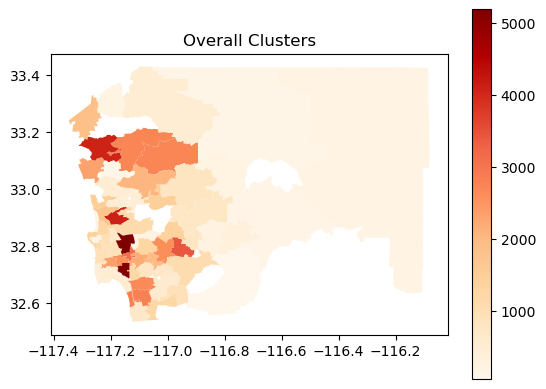

In [91]:
index_and_counts = generate_counts(final_merge)
_df = process_centers(index_and_counts)
_df = generate_clusters(_df)
groupby_tracts = merge_tracts(full_merge,_df,tracts)
dissolved = geometries_to_tracts(groupby_tracts,10)
dissolved.plot(column='count',legend=True,cmap='OrRd').set_title('Overall Clusters')

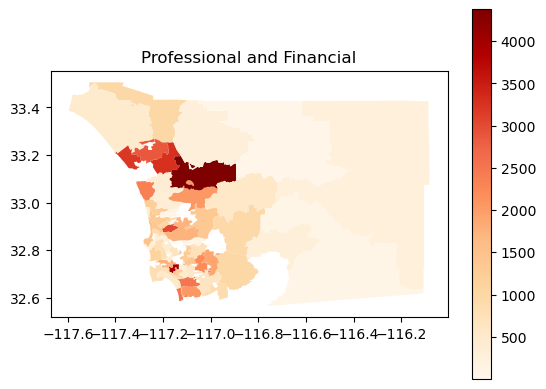

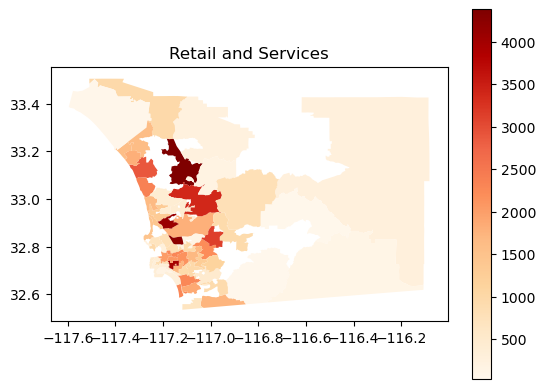

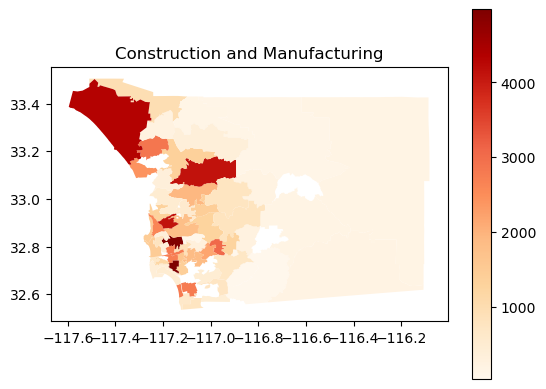

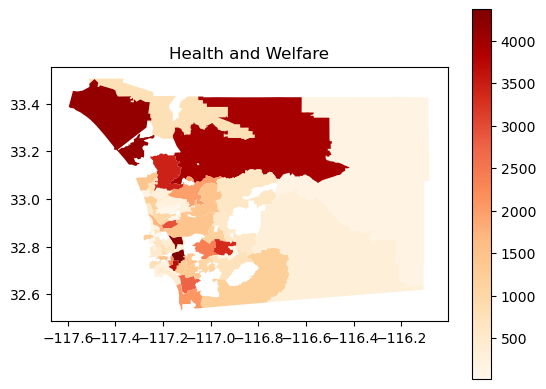

In [99]:
import warnings
warnings.filterwarnings('ignore')
for i in final_merge['Categories'].unique():
    index_and_counts = generate_counts(final_merge[final_merge['Categories']==i])
    _df = process_centers(index_and_counts)
    _df = generate_clusters(_df)
    groupby_tracts = merge_tracts(full_merge,_df,tracts)
    dissolved = geometries_to_tracts(groupby_tracts)
    dissolved.plot(column='count',legend=True,cmap='OrRd').set_title(i)
    dissolved.to_file('../output/'+i+'.shp')
    # dissolved['count'].plot(kind='hist')

<Axes: ylabel='Frequency'>

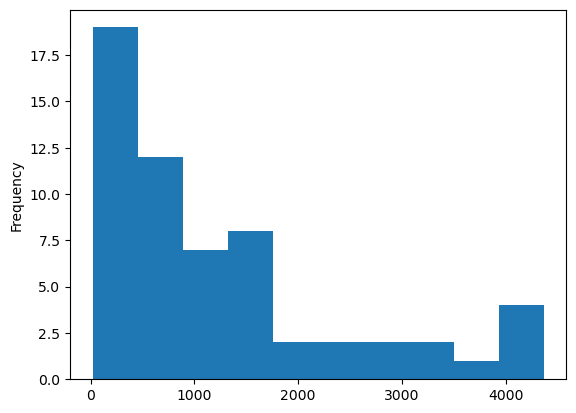

In [98]:
dissolved['count'].plot(kind='hist')